# lecture

최규빈  
2025-05-19

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/09wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [2]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-yrZ4HbNgYDmklcumxJHSOp&si=XO2ZBUtY_m1mSFvX >}}

# 2. Imports

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 3. 예비학습

## A. `tanh`

## B. `softmax`

# 4. `abc`

## A. Data

In [25]:
txt = list('abc'*100)
txt[:10]

In [26]:
df_train = pd.DataFrame({'x': txt[:-1], 'y': txt[1:]})
df_train[:5]

In [27]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2}))

## B. MLP – 하나의 은닉노드

`-` 적합

`-` 결과시각화

`-` 시각화결과해석: 학습이 잘 된것 같지만 깔끔하지 않음.

-   netout 을 보는 요령: 가장 빨간부분이 예측값이 된다.
-   문제1: $out_b$의 경우 애매한 색깔만 있음. 네트워크가 정답을 잘
    모른다는 의미.
-   문제1의 원인: $out_b$의 경우에 대응하는 ${\boldsymbol h}$를 살펴보니
    흰색임. 이것은 값이 0이라는 의미인데 이때는 ${\boldsymbol h}$ 에
    걸리는 선형변환 $linr$ 의 weight 가 의미없고 bias만 의미있기 때문에
    특징을 잡기에 불리하다.
-   문제2: ${\boldsymbol h}$가 흰색이면(=0이 나오면) 불리하며, 확실한
    색을 가지고 있는것이 유리함. 그렇지만 확실한 색인 빨강 파랑은 이미
    차지된 상태라서 어쩔수 없이 흰색으로 선택된 것.
-   문제2를 해결하는 방법: $a,b,c$라는 세문자를 표현하기에
    $(-1,1)$사이의 숫자는 너무 불리함..

## C. MLP – 두개의 은닉노드

`-` 적합

`-` 결과시각화

`-` 시각화결과해석: 깔끔함. netout의 가장 빨간부분도 너무 명확함.
${\boldsymbol h}$가 0이 아닌 값으로 학습되어있음

-   x=a $\Rightarrow$ h=(파,빨) $\Rightarrow$ y=b
-   x=b $\Rightarrow$ h=(빨,파) $\Rightarrow$ y=c
-   x=c $\Rightarrow$ h=(빨,빨) $\Rightarrow$ y=a
-   h = (파,파) 는 사용하지 않음. –\> 문자열 d를 하나 더 쓸수 있는
    공간이 $h$에 있다고 해석할 수 있음..

# 5. `abcd`

## A. Data

In [7]:
txt = list('abcd'*100)
txt[:10]

In [8]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [9]:
x = torch.tensor(df_train.x.map({'a':0, 'b':1, 'c':2, 'd':3}))
y = torch.tensor(df_train.y.map({'a':0, 'b':1, 'c':2, 'd':3}))

## B. MLP – 하나의 은닉노드

`-` 적합

`-` 결과시각화

## C. MLP – 두개의 은닉노드

`-` 적합

`-` 결과시각화

## D. 비교실험

In [140]:
class Net1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.ebdd = torch.nn.Embedding(4,1)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(1,4)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h)
        ## 정의 끝
        return netout

In [141]:
class Net2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.ebdd = torch.nn.Embedding(4,2)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(2,4)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h)
        ## 정의 끝
        return netout

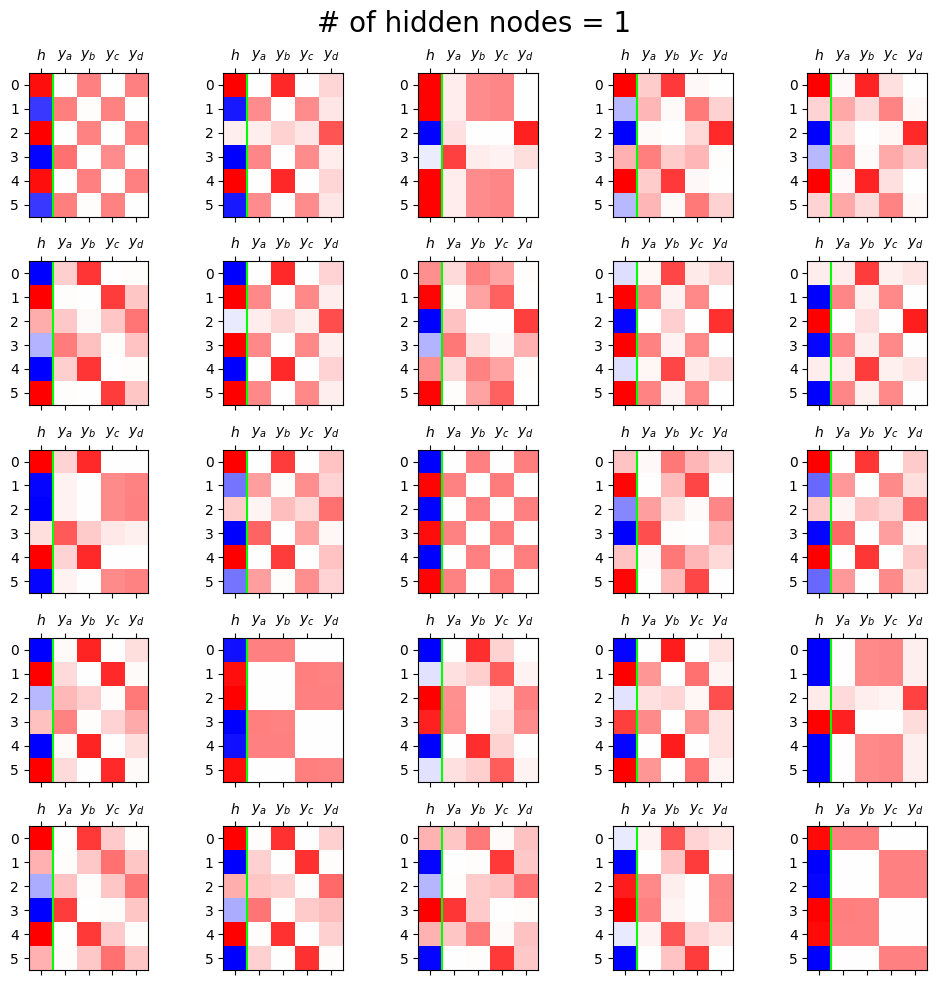

In [145]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Net1()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoc in range(50):
            ## 1 
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data
        yhat = torch.nn.functional.softmax(net(x),dim=1).data
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat[:6, :],cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(0.5,color='lime')
        ax[i][j].set_xticks(ticks=[0,1,2,3,4],labels=[r"$h$",r"$y_a$",r"$y_b$",r"$y_c$",r"$y_d$"])
fig.suptitle("# of hidden nodes = 1", size=20)
fig.tight_layout()

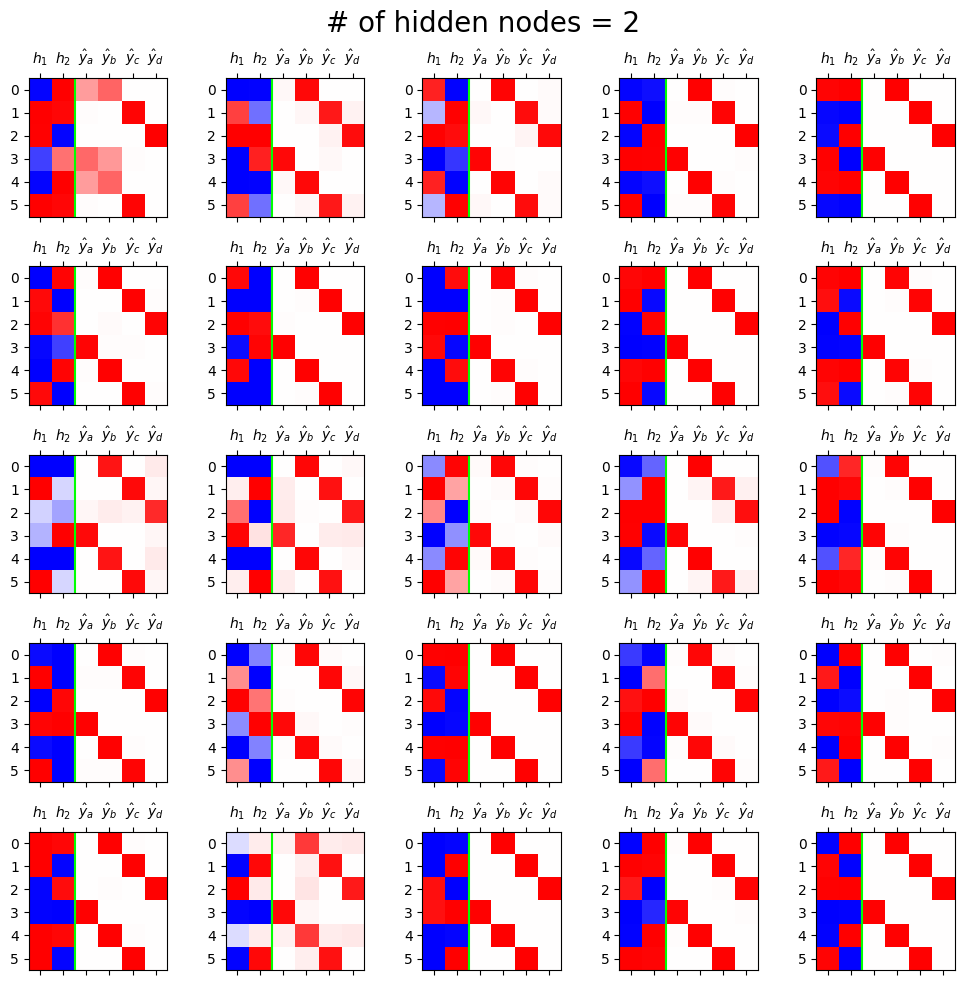

In [147]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Net2()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoc in range(50):
            ## 1 
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data
        yhat = torch.nn.functional.softmax(net(x),dim=1).data
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat[:6, :],cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(1.5,color='lime')
        ax[i][j].set_xticks(ticks=[0,1,2,3,4,5],labels=[r"$h_1$",r"$h_2$",r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"])
fig.suptitle("# of hidden nodes = 2", size=20)
fig.tight_layout()        

# 6. ${\boldsymbol h}$ 에 대하여 $(\star\star\star$)

`-` ${\boldsymbol h}$는 사실 문자열 “abcd”들을 숫자로 바꾼 표현이라
해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할
수 있다.

`-` 사실 ${\boldsymbol h}$는 원핫인코딩보다 약간 더 (1) 액기스만 남은
느낌 + (2) 숙성된 느낌을 준다

-   (why1) ${\boldsymbol h}$는 ${\boldsymbol x}$ 보다
    ${\boldsymbol y}$를 예측함에 좀 더 직접적인 역할을 한다. 즉
    ${\boldsymbol x}$ 숫자보다 ${\boldsymbol h}$ 숫자가 잘 정리되어 있고
    (차원이 낮고) 입력의 특징을 잘 정리한 (추천시스템의 MBTI처럼)
    의미있는 숫자이다.
-   (why2) ${\boldsymbol x}$는 학습없이 그냥 얻어지는 숫자표현이지만,
    ${\boldsymbol h}$는 학습을 통하여 고치고 고치고 고친 숫자표현이다.

# 7. `AbAbAc` – 실패

## A. Data

In [10]:
txt = list('AbAcAd'*50)
txt[:10]

In [11]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [12]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))

In [13]:
x[:8],y[:8]

## B. MLP – 두개의 은닉노드 (실패)

`-` 적합

`-` 결과시각화

-   100번 시도해봤자 100번 망함

## C. Discussions

`-` 왜 망했을까?

`-` `hello`[1] 문자열을 맞출 수 있을까?

-   이전시점을 많이 고려하면 맞출수는 있음.
-   그러나 이러한 방법들은 (ARMA, N-grams) 한계가 뚜렷 $\to$
    순환신경망의 등장

# 8. 씨간장

***(생각1) [수백년전통을 이어가는
방법](https://www.joongang.co.kr/article/24087690#home)***

    “1리터에 500만원에 낙찰된 적 있습니다.”
    “2kg에 1억원 정도 추산됩니다.”
    “20여 종 종자장을 블렌딩해 100ml에 5000만원씩 분양 예정입니다.”

    모두 씨간장(종자장) 가격에 관한 실제 일화다.

    (중략...)

    위스키나 와인처럼 블렌딩을 하기도 한다. 
    새로 담근 간장에 씨간장을 넣거나, 씨간장독에 햇간장을 넣어 맛을 유지하기도 한다. 
    이를 겹장(또는 덧장)이라 한다. 
    몇몇 종갓집에선 씨간장 잇기를 몇백 년째 해오고 있다. 
    매년 새로 간장을 담가야 이어갈 수 있으니 불씨 꺼트리지 않는 것처럼 굉장히 어려운 일이다.
    이렇게 하는 이유는 집집마다 내려오는 고유 장맛을 잃지 않기 위함이다. 
    씨간장이란 그만큼 소중한 주방의 자산이며 정체성이다.

덧장: 새로운간장을 만들때, 옛날간장을 섞어서 만듬

`*` 기존방식 -
$\text{콩물} \overset{\text{숙성}}{\longrightarrow} \text{간장}$

`*` 수백년 전통의 간장맛을 유지하는 방식

-   $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3$

`*` 수백년 전통의 간장맛을 유지하면서 조리를 한다면?

-   $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

점점 맛있는 간장계란밥이 탄생함

`*` 알고리즘의 편의상 아래와 같이 생각해도 무방

-   $\text{콩물}_1, \text{간장}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$,
    $\text{간장}_0=\text{맹물}$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

***아이디어***

`*` 수백년 전통의 간장맛을 유지하면서 조리하는 과정을 수식으로? (콩물을
$x$로, 간장을 $h$로!!)

-   $\boldsymbol{x}_1, \boldsymbol{h}_0 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_1 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_1$
-   $\boldsymbol{x}_2, \boldsymbol{h}_1 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_2 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_2$
-   $\boldsymbol{x}_3, \boldsymbol{h}_2 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_3 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_3$

이제 우리가 배울것은 (1) “$\text{콩물}_{t}$”와 “$\text{간장}_{t-1}$”로
“$\text{간장}_t$”를 `숙성`하는 방법 (2) “$\text{간장}_t$”로
“$\text{간장계란밥}_t$를 `조리`하는 방법이다

즉 `숙성`담당 네트워크와 `조리`담당 네트워크를 각각 만들어 학습하면
된다.

***(생각2) ${\boldsymbol h}$에 대한 이해***

`-` ${\boldsymbol h}$는 사실 문자열 “abc, abcd”들을 숫자로 바꾼 표현이라
해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할
수 있다.

`-` 사실 ${\boldsymbol h}$는 원핫인코딩보다 약간 더 (1) 액기스만 남은
느낌 + (2) 숙성된 느낌을 준다

-   (why1) ${\boldsymbol h}$는 ${\boldsymbol x}$ 보다
    ${\boldsymbol y}$를 예측함에 좀 더 직접적인 역할을 한다. 즉
    ${\boldsymbol x}$ 숫자보다 ${\boldsymbol h}$ 숫자가 잘 정리되어 있고
    (차원이 낮고) 입력의 특징을 잘 정리한 (추천시스템의 MBTI처럼)
    의미있는 숫자이다.
-   (why2) ${\boldsymbol x}$는 학습없이 그냥 얻어지는 숫자표현이지만,
    ${\boldsymbol h}$는 학습을 통하여 고치고 고치고 고친 숫자표현이다.

결론: 사실 ${\boldsymbol h}$는 잘 숙성되어있는 입력정보
${\boldsymbol x}$ 그 자체로 해석 할 수 있다.

[1] 2015년 Andrej Karpathy(안드레이 카파시)의 “전설적인” 블로그
<https://karpathy.github.io/2015/05/21/rnn-effectiveness/> 에 담긴 예제